In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import numpy as np
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(11, 7)
plt.rcParams["figure.autolayout"] = True

----
<h2 style="text-align:center;">Base Model</h2>

---


### Data loading and preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [5]:
education = {'Bachelors': 0, 'Masters':1, 'PHD': 2}
oce_columns = ["City", "Gender", "EverBenched"]
target_col = 'LeaveOrNot'

In [6]:
raw_data = pd.read_csv('data/employee/Employee.csv')

true_raw = raw_data.loc[raw_data[target_col] == 1]
n_true = len(true_raw)
false_raw = raw_data.loc[~(raw_data[target_col] == 1)].sample(n_true)

raw_data = pd.concat([false_raw, true_raw]).sample(frac=1)
raw_data.index = np.arange(len(raw_data), dtype=int)

In [7]:
data = raw_data.copy()
data['Education'] = data['Education'].map(education)

data = pd.get_dummies(data=data, columns=oce_columns, drop_first=False, dtype=int)

data.head()

,Education,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes
0,0,2015,3,28,2,1,0,0,1,1,0,0,1
1,0,2015,3,25,3,1,1,0,0,1,0,1,0
2,0,2017,2,24,2,1,0,0,1,1,0,1,0
3,1,2015,2,25,3,1,0,0,1,1,0,1,0
4,0,2016,3,39,3,1,1,0,0,1,0,1,0


In [8]:
raw_data

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2015,Pune,3,28,Female,Yes,2,1
1,Bachelors,2015,Bangalore,3,25,Female,No,3,1
2,Bachelors,2017,Pune,2,24,Female,No,2,1
3,Masters,2015,Pune,2,25,Female,No,3,1
4,Bachelors,2016,Bangalore,3,39,Female,No,3,1
...,...,...,...,...,...,...,...,...,...
3195,Bachelors,2017,New Delhi,2,39,Female,No,0,0
3196,Bachelors,2016,Bangalore,3,26,Male,No,4,0
3197,Bachelors,2015,Pune,2,28,Female,No,1,1
3198,Bachelors,2014,Bangalore,3,35,Female,No,2,1


In [9]:
scaler = StandardScaler()

target = data[target_col].values
data = data.drop(target_col, axis='columns')

columns = data.columns.values
data = scaler.fit_transform(data.values)
data = pd.DataFrame(data=data, columns=columns)
data[target_col] = target
data.head()

,Education,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,LeaveOrNot
0,-0.525826,-0.086718,0.590220,-0.261754,-0.576092,-0.915437,-0.561951,1.512877,1.134614,-1.134614,-2.895542,2.895542,1
1,-0.525826,-0.086718,0.590220,-0.887149,0.071430,1.092375,-0.561951,-0.660992,1.134614,-1.134614,0.345358,-0.345358,1
2,-0.525826,0.968404,-1.137781,-1.095614,-0.576092,-0.915437,-0.561951,1.512877,1.134614,-1.134614,0.345358,-0.345358,1
3,1.408247,-0.086718,-1.137781,-0.887149,0.071430,-0.915437,-0.561951,1.512877,1.134614,-1.134614,0.345358,-0.345358,1
4,-0.525826,0.440843,0.590220,2.031361,0.071430,1.092375,-0.561951,-0.660992,1.134614,-1.134614,0.345358,-0.345358,1


### model trainging

In [10]:
from torch import nn
import torch
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, Dataset
from DeepCore.deepcore.nets.nets_utils import recorder

from teste import ClassifierDataset

torch.manual_seed(RANDOM_SEED)

In [11]:
def base_view(df, title, xlabel, ylabel, hline=None, plot=True,**kwargs):
    sns.lineplot(df, lw=3, **kwargs)
    if 'ax' in kwargs:
        kwargs['ax'].set_title(title, fontsize=20)
        kwargs['ax'].set_xlabel(xlabel, fontsize=16)
        kwargs['ax'].set_ylabel(ylabel, fontsize=16)
        if hline:
            kwargs['ax'].axhline(hline, linestyle='--',c='black', alpha=.4)
    else:
        plt.title(title, fontsize=20)
        plt.xlabel(xlabel, fontsize=16)
        plt.ylabel(ylabel, fontsize=16)
        if hline:
            plt.axhline(hline, linestyle='--',c='black', alpha=.4)
    plt.tight_layout()
    if plot:
        plt.show()

In [12]:
def block_factory(in_features=2, out_features=2, device='cpu', args=[]):
    layer_set = [
        nn.Linear(in_features=in_features, out_features=out_features, device=device, bias=True),
        nn.ReLU()
    ]
    return nn.Sequential(*layer_set)

class Classifier(nn.Module):
    device = 'gpu' if torch.cuda.is_available() else 'cpu'
    def __init__(self, in_features, out_features, dropout=.5):
        super().__init__()
        self.input_layer = block_factory(in_features=in_features, out_features=128)
        self.hidden = block_factory(in_features=128, out_features=128)
        self.hidden1 = block_factory(in_features=128, out_features=64)
        self.hidden2 = block_factory(in_features=64, out_features=out_features)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
        self.embedding_recorder = recorder.EmbeddingRecorder(record_embedding=True)
    def forward(self, x):
        x = self.dropout(self.input_layer(x))
        x = self.hidden(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.embedding_recorder(x)
        x = self.sigmoid(x)
        return x 
        # return x.round()
    def get_last_layer(self):
        return self.hidden[0]

In [13]:
import torch.nn.functional as F

def map_error(df, target_col, model):
    pred = predict(df, target_col, model)
    target = torch.Tensor(df[target_col].values).unsqueeze(1)
    error = F.binary_cross_entropy(pred, target, reduction='none').detach().numpy()
    return error

In [14]:
def predict(df, tgt, model):
    d = df.drop(tgt, axis='columns').values
    d = torch.Tensor(d)
    return model(d)

def eval_model(model, ds, l_func):
    model.eval()
    n = len(ds)
    with torch.no_grad():
        batch_loss = 0
        for batch in ds:
            features, labels = batch.items()
            _, labels = labels
            _, features = features
            pred = model(features.to('cpu'))
            e_loss = l_func(pred, labels)
            batch_loss += e_loss.item() / len(ds)            
    return batch_loss

def train(model, optmizer, loss_fn, data_train, epochs, data_val=None, data_test=None, callback=None, callback_kwargs=None):                
    model.to('cpu')
    model.train(True)
    train_loss = []
    test_loss = []
    val_loss = []
    hist = dict()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in data_train:
            features, labels = batch.items()
            labels = labels[1].float().to('cpu')
            features = torch.autograd.Variable(features[1], requires_grad=True).float().to('cpu')
            pred = model(features)
            loss = loss_fn(pred, labels)
            epoch_loss += loss.item()
            optmizer.zero_grad()
            loss.backward()
            optmizer.step()
        epoch_loss /= len(data_train)
        train_loss.append(epoch_loss)
        if data_test:
            t_loss = eval_model(model, data_test, l_func=loss_fn)
            test_loss.append(t_loss)
        if data_val:
            t_loss = eval_model(model, data_val, l_func=loss_fn)
            val_loss.append(t_loss)
        model.train(True)
    model.eval()
    hist['train_loss'] = train_loss
    if data_test:
        
        hist['test_loss'] = test_loss
    if data_val:
        hist['val_loss'] = val_loss
    return hist

In [15]:
batch_size = 32

generator = torch.Generator().manual_seed(RANDOM_SEED)


dataset = ClassifierDataset(dataframe=data, target=target_col)

ds_train, ds_test, ds_val = random_split(dataset=dataset, lengths=[0.8, 0.1, 0.1], generator=generator, )

ds_train = DataLoader(dataset=ds_train, batch_size=batch_size)
ds_test = DataLoader(dataset=ds_test, batch_size=batch_size)
ds_val = DataLoader(dataset=ds_val, batch_size=batch_size)

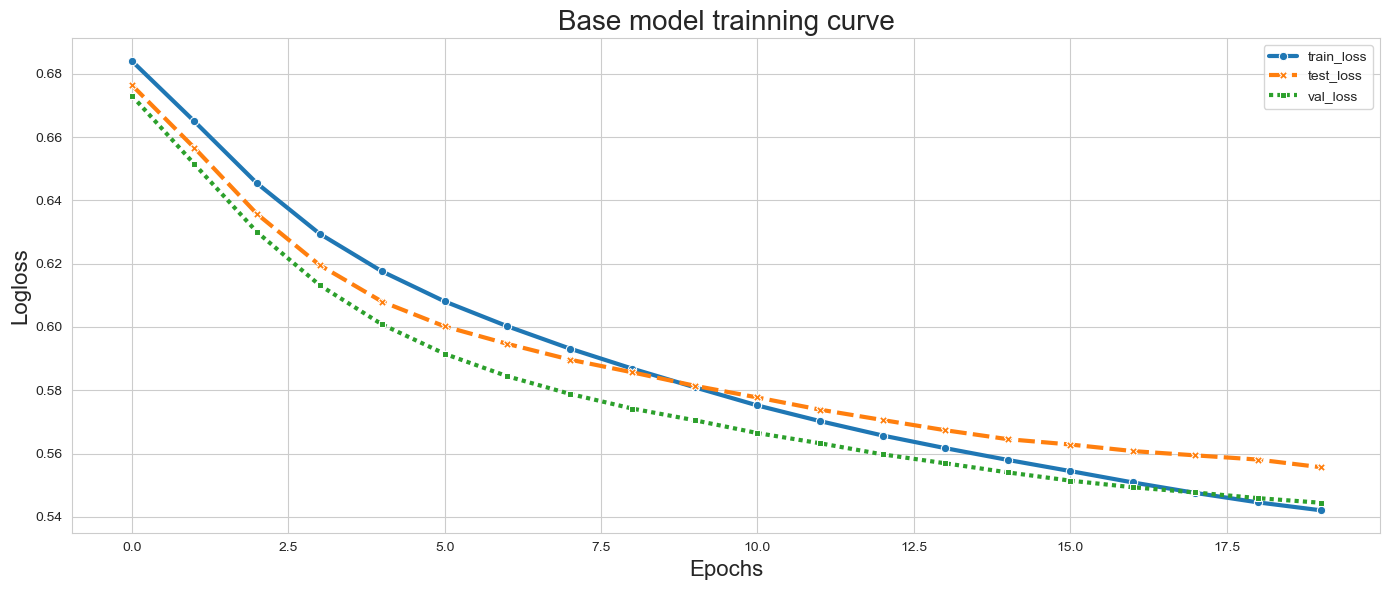

In [16]:
n_epochs = 20
lr = 10e-5
in_features = data.shape[1] - 1
loss_fn = nn.BCELoss()
base_model = Classifier(in_features=in_features, out_features=1, dropout=0.0)
optmizer = Adam(lr=lr, params=base_model.parameters())
hist = train(model=base_model, optmizer=optmizer, loss_fn=loss_fn, data_train=ds_train, data_test=ds_test, data_val=ds_val, epochs=n_epochs)
        
fig, ax = plt.subplots(figsize=(14, 6))
base_view(hist, title='Base model trainning curve', xlabel='Epochs', ylabel='Logloss', markers=True)

In [17]:
from sklearn.metrics import classification_report

base_pred = predict(data, tgt=target_col, model=base_model).squeeze(1).detach().numpy().round()
report = classification_report(y_true=data[target_col].values, y_pred=base_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      1600
           1       0.84      0.63      0.72      1600

    accuracy                           0.75      3200
   macro avg       0.77      0.75      0.75      3200
weighted avg       0.77      0.75      0.75      3200



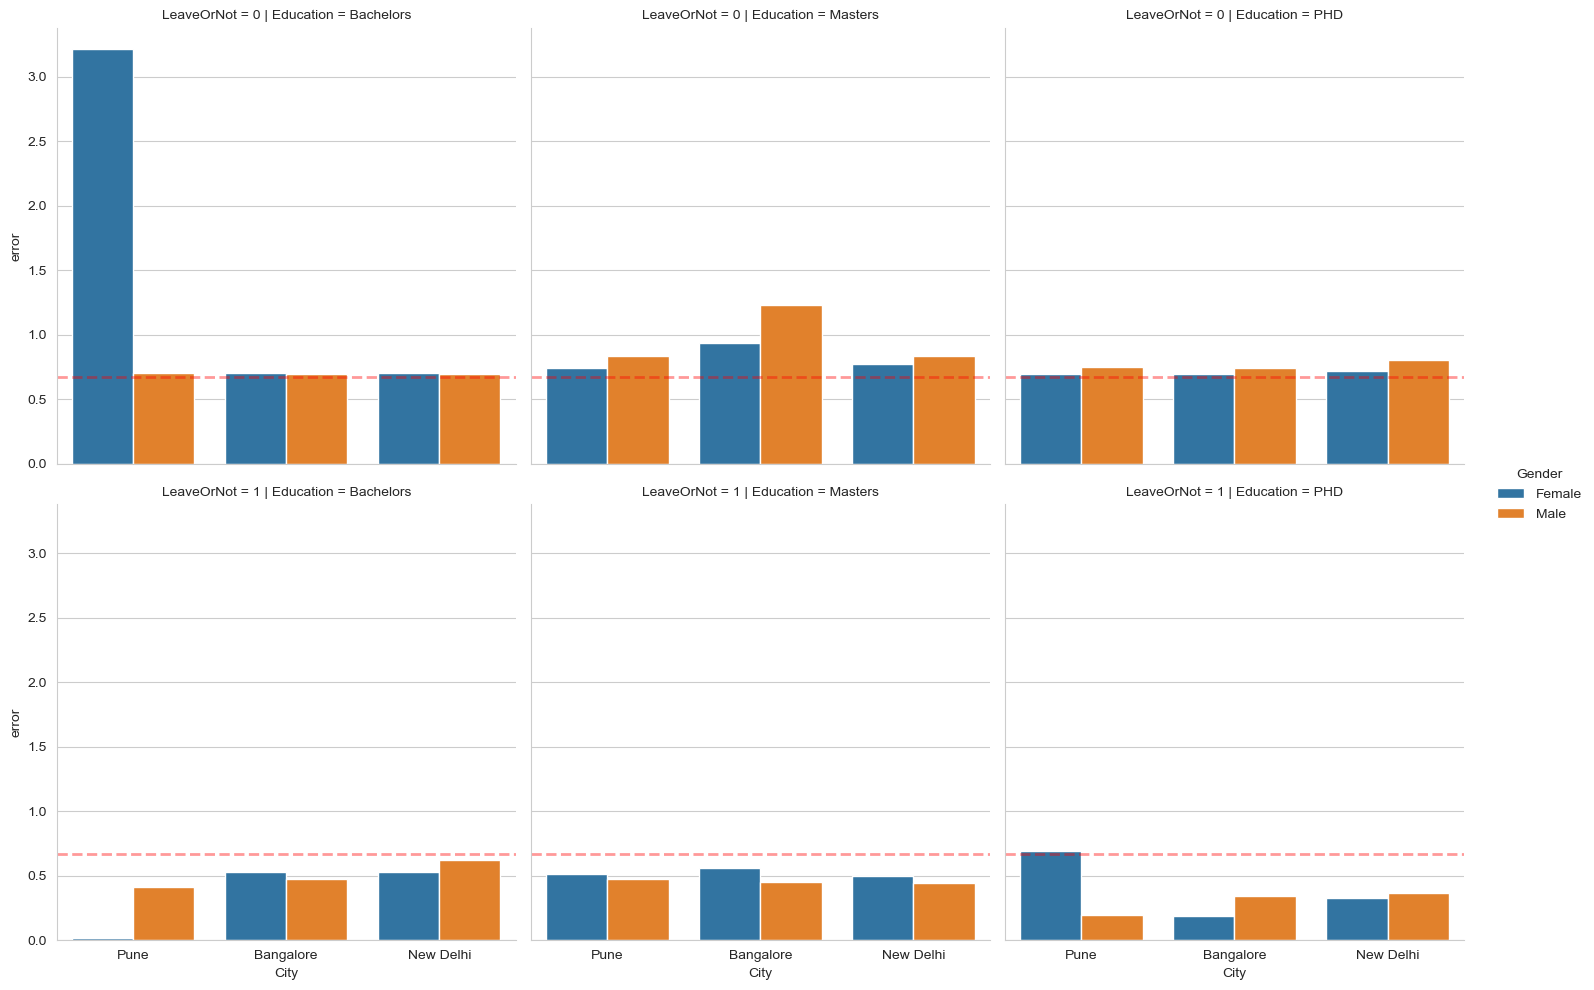

In [18]:
base_model_data = raw_data.copy()
base_model_data['error'] = map_error(df=data, model=base_model, target_col=target_col).squeeze(1)

base_model_data = base_model_data[['Gender', target_col, 'error', 'City', 'Education']].groupby(['Gender', target_col, 'City', 'Education'], as_index=False).mean().sort_values('error', ascending=False)

g = sns.catplot(data=base_model_data, x='City', y='error', kind='bar', hue='Gender', row=target_col, col='Education', )

g.refline(y=base_model_data.error.mean(), color='red', alpha=.4, lw=2)

----
<h2 style="text-align:center;">Slice Finder <b>S</b></h2>

---

### Base line:

In [19]:
def parse_predicates(in_names, slices):
    for s in slices:
        indices = np.where(s)
        yield zip(in_names[indices], s[indices])

def parse_query(predicates_gen):
    slices = next(predicates_gen)
    while slices:
        try:
            prox = next(slices)
            query = ''
            while prox:
                name, value = prox
                if isinstance(value, str):
                    query += f'{name} == "{value}"'
                else:
                    query += f'{name} == {value}'
                try:
                    prox = next(slices)
                    query += ' and '
                except StopIteration:
                    yield query
                    break
            slices = next(predicates_gen)
        except StopIteration:
            break

def get_indices(dataset, query_parser):
    return [dataset.query(query).index.values for query in query_parser]
    # yield from [dataset.query(query).index.values for query in query_parser]

## Base model evaluation:

### Efect size $\phi$

> 
> $\phi = \sqrt{2} \frac{\omega(S, h) - \omega(S', h)}{\sqrt{\sigma^2_{S} - \sigma^2_{S'}}}$ 
> 
>
> - $\omega(S, h)$: Loss function considering the pair (Dataset, Model)
> - $\sigma^2_{S}$: Loss function variance

In [20]:
def efect_size(pred_error, slice_idx, idx):
    mask = np.isin(idx, slice_idx)
    not_mask = ~mask
    slice_error = pred_error[mask]
    complement_error = pred_error[not_mask]
    error = np.mean(slice_error) - np.mean(complement_error)
    slice_var = np.var(slice_error)
    complement_var = np.var(complement_error)
    std = np.sqrt(slice_var + complement_var)
    return (2 ** 0.5) * (error / std)

In [21]:
from sliceline.slicefinder import Slicefinder
from itertools import product

k_alpha = np.linspace(.9, 1, 4).round(2)
k_min_sup =  np.linspace(.1, .7, 4).round(2)

error = map_error(df=data, target_col=target_col, model=base_model)
slice_data = raw_data.drop(target_col, axis='columns')

base_result = []
for k in range(1,  10):
    print(f"-------------------- SliceFinder k == {k} ---------------------")
    for alpha, min_sup in product(k_alpha, k_min_sup):
        # print(f"evaluating SliceFinder for alpha = {alpha:.2f}  ", end="-> ")
        slice_finder = Slicefinder(alpha=alpha, min_sup=min_sup, verbose=False, k=k)
        slice_finder.fit(slice_data, errors=error)
        
        predicates = parse_predicates(in_names=slice_finder.feature_names_in_, slices=slice_finder.top_slices_)
        query_parser = parse_query(predicates)
        slice_indices = get_indices(raw_data, query_parser)
        e_size = [efect_size(pred_error=error, slice_idx=i, idx=data.index) for i in slice_indices]
        for i, top_slice in enumerate(slice_finder.top_slices_statistics_):
            result_k = {
                'k': k,
                'alpha': alpha,
                'min_sup': min_sup,
                'avg_loss': top_slice['slice_average_error'],
                'slice_size': top_slice['slice_size'],
                'efect_size': e_size[i]
            }
            base_result += [result_k]
base_result = pd.DataFrame.from_records(base_result)

-------------------- SliceFinder k == 1 ---------------------
-------------------- SliceFinder k == 2 ---------------------
-------------------- SliceFinder k == 3 ---------------------
-------------------- SliceFinder k == 4 ---------------------
-------------------- SliceFinder k == 5 ---------------------
-------------------- SliceFinder k == 6 ---------------------
-------------------- SliceFinder k == 7 ---------------------
-------------------- SliceFinder k == 8 ---------------------
-------------------- SliceFinder k == 9 ---------------------


#### Slice Size:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


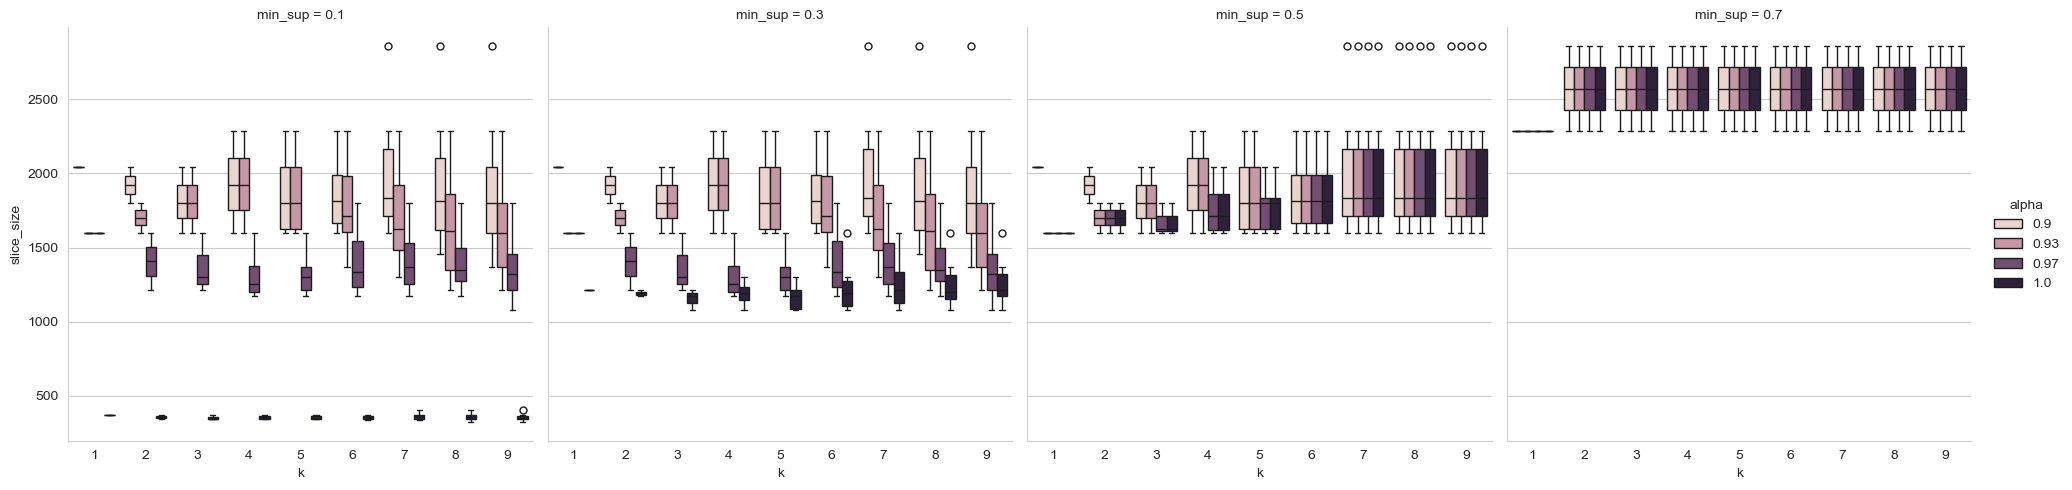

In [22]:
sns.catplot(data=base_result, x='k', y='slice_size', col='min_sup', hue='alpha', kind='box')

#### Avg loss:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


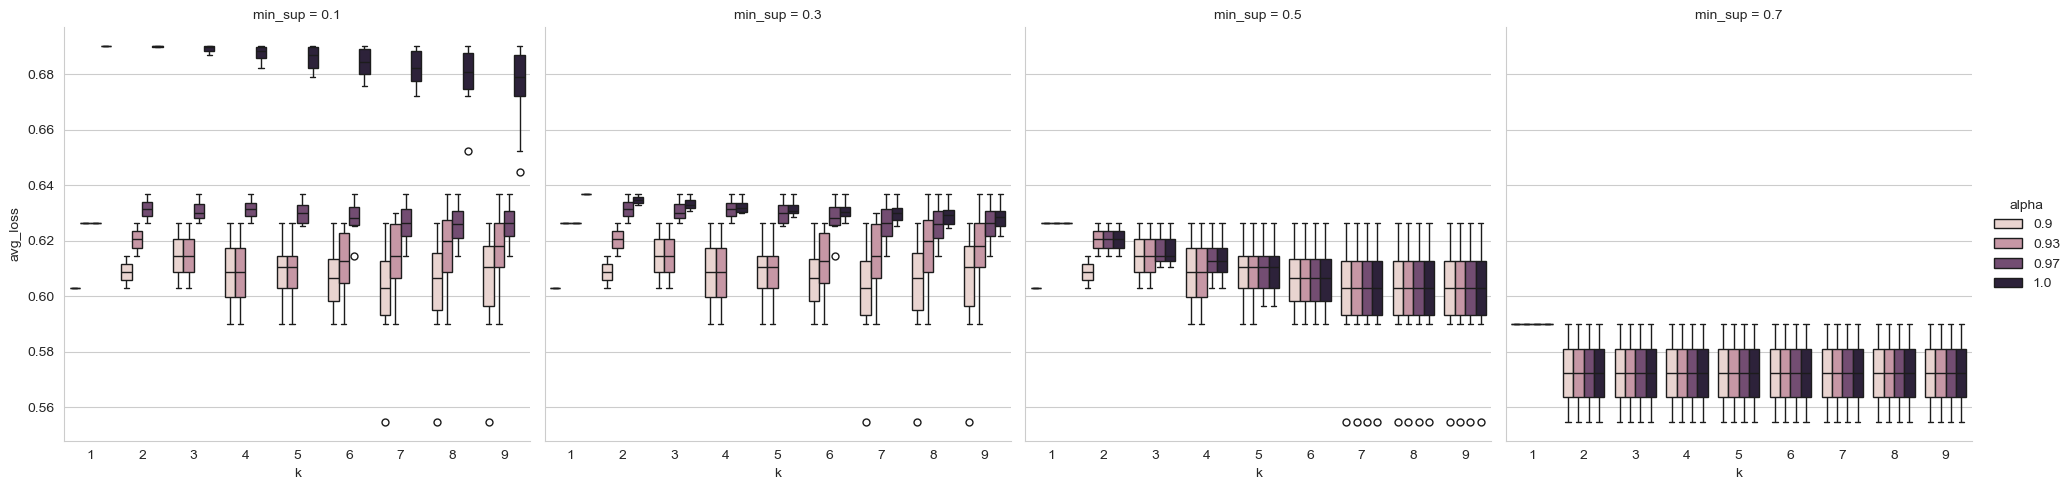

In [23]:
sns.catplot(data=base_result, x='k', y='avg_loss', col='min_sup', hue='alpha', kind='box')

#### Efecti size:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


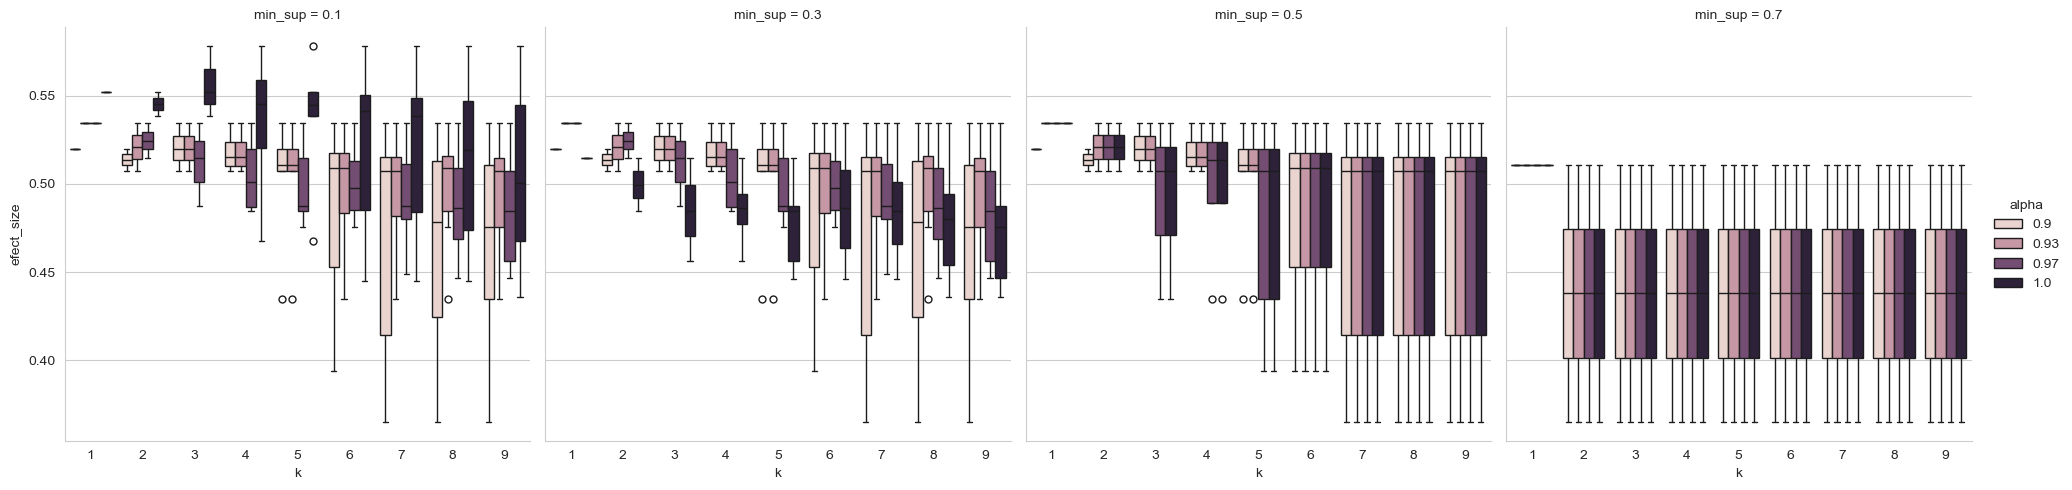

In [24]:
sns.catplot(data=base_result, x='k', y='efect_size', col='min_sup', hue='alpha', kind='box')

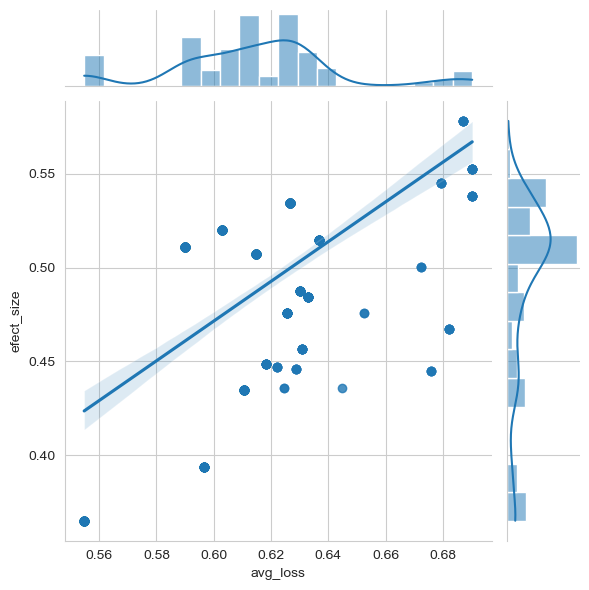

In [25]:
# aqui
sns.jointplot(data=base_result, x='avg_loss', y='efect_size',robust=True,kind='reg')
plt.tight_layout()
plt.show()

### Coverage metric **N**

number of common items within a sample and a hole dataset

In [26]:
def coverage(sample_slice_indices, slice_base_indices):
    mask = np.isin(sample_slice_indices, slice_base_indices)
    true_indices = sample_slice_indices[mask]
    return len(true_indices) / len(sample_slice_indices)

In [27]:
pred_error = map_error(df=data, target_col=target_col, model=base_model)
slice_finder = Slicefinder(alpha=1, min_sup=.3, verbose=False, k=1)
slice_finder.fit(raw_data.drop(target_col, axis='columns'), pred_error)

predicates = parse_predicates(
    in_names=slice_finder.feature_names_in_,
    slices=slice_finder.top_slices_
)

query_parser = parse_query(predicates_gen=predicates)
full_indices = get_indices(dataset=raw_data, query_parser=query_parser)

In [36]:
from itertools import product
n_sample = np.linspace(10e-3, 1, 20)

frac_cov = []

for i in range(100):
    for frac in n_sample:
        sample = raw_data.sample(frac=frac)
        sample_index = sample.index.values

        pred_error = map_error(df=data.iloc[sample_index], target_col=target_col, model=base_model)
        slice_finder = Slicefinder(alpha=1, min_sup=.3, verbose=False, k=1)
        slice_finder.fit(sample.drop(target_col, axis='columns'), pred_error)

        predicates = parse_predicates(
            in_names=slice_finder.feature_names_in_,
            slices=slice_finder.top_slices_
        )

        query_parser = parse_query(predicates_gen=predicates)
        sample_slice_indices = get_indices(dataset=sample, query_parser=query_parser)
        for sample_indices, base_indices in zip(sample_slice_indices, full_indices):
            result = {
                'acc': coverage(sample_slice_indices=sample_indices, slice_base_indices=base_indices),
                'frac': frac
            }
            frac_cov += [result]
frac_cov = pd.DataFrame.from_records(frac_cov)

([<matplotlib.axis.XTick at 0x166c8a190>,
 [Text(0.01, 0, '0.01'),
  Text(0.12, 0, '0.12'),
  Text(0.23, 0, '0.23'),
  Text(0.34, 0, '0.34'),
  Text(0.45, 0, '0.45'),
  Text(0.56, 0, '0.56'),
  Text(0.67, 0, '0.67'),
  Text(0.78, 0, '0.78'),
  Text(0.89, 0, '0.89'),
  Text(1.0, 0, '1.00')])

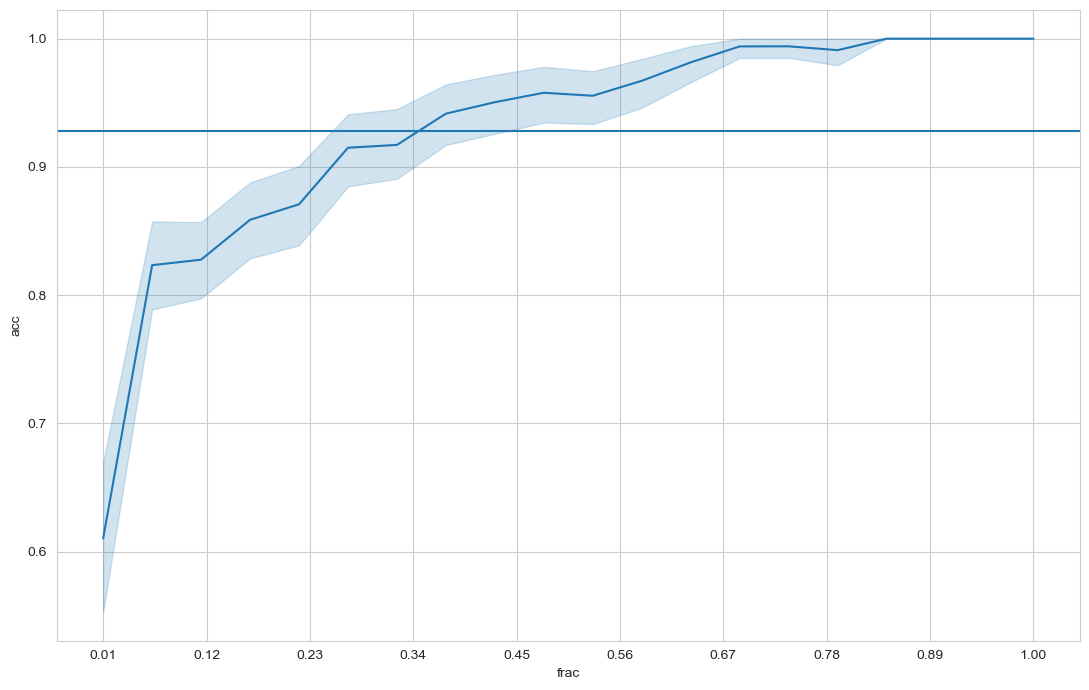

In [42]:
sns.lineplot(data=frac_cov, x='frac', y='acc', markers=True, dashes=False)
plt.axhline(frac_cov.acc.mean())
plt.xticks(np.linspace(10e-3, 1, 10).round(2))